# CLUST Motion Tracking Project
Mélanie Bernhardt - ETH Zurich - Data Science MSc

This notebook provides a simple way to train the model, to predict the location of features from a saved model and to visualize the predictions. 

### First set up the environment
WARNING: in order to be able to run this notebook the `DATA_PATH`, `EXP_PATH`and `TEST_PATH` have to be properly set prior to starting the jupyter server. 

In [1]:
from dataLoader import DataLoader
from network import create_model
from custom_KFold import MyKFold
from utils import get_logger, get_default_params, plot_img_template
from global_tracking import train, predict, run_global_cv
import os
import logging
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from IPython import display

## Define the parameters of the experiment

In [2]:
# ============ DATA AND SAVING DIRS SETUP ========== #
data_dir = os.getenv('DATA_PATH')
test_dir = os.getenv('TEST_PATH')
exp_dir = os.getenv('EXP_PATH')

In [ ]:
exp_name = '2layers_new'
params_dict = {'dropout_rate': 0.5, 'n_epochs': 100,
               'h3': 0, 'embed_size': 128, 'width': 60}

checkpoint_dir = os.path.join(exp_dir, exp_name)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
params_dict = get_default_params(params_dict)

## Option 1: train the model from scratch
If a validation generator is provided then it uses early stopping else not. `train` automatically saves the model weigths and the temporal estimators to the checkpoint dir (necessary for `predict` to work properly).

In [ ]:
traindirs = np.asarray([dI for dI in os.listdir(data_dir) if (
                        os.path.isdir(os.path.join(data_dir, dI))
                        and not dI == 'feats_matrices')])
model, est_c1, est_c2 = train(traindirs, data_dir,
                              upsample=False, 
                              params_dict=params_dict,
                              checkpointdir=checkpoint_dir,
                              logger=None,
                              validation_gen=None)

## Option 2: Predict from a saved model
The `predict` function restores the models saved in the `checkpoint_dir`. It runs computes the feature location for every frame of every sequences in the test directories. For each test sequence, the results are saved in a tab separated file named `SequenceName_PointNumber.txt` (as required by the submission format of the CLUST Challenge). The files are also stored in the `checkpoint_dir`.

In [ ]:
testdirs = np.asarray([dI for dI in os.listdir(test_dir) if (
                        os.path.isdir(os.path.join(test_dir, dI))
                        and not dI == 'feats_matrices')])
predict(testdirs, checkpoint_dir, data_dir, params_dict)

## Option 3: Run the cross-validation on the whole procedure
Runs the across-sequence cross-validation. Each neural model + temporal models are trained on 20 sequences and then predictions are computed for the remaining 4 sequences (5-folds). The results are recorded in a `logfile.log` in the checkpoint directory.  

In [48]:
# ========== LOGGER SETUP ======== #
logger = get_logger(checkpoint_dir)

# ========= PRINT CONFIG TO LOG ======== #
logger.info('Running %s experiment ...' % exp_name)
logger.info('\n Settings for this expriment are: \n')
for key in params_dict.keys():
    logger.info('  {}: {}'.format(key.upper(), params_dict[key]))
logger.info('Saving checkpoint to {}'.format(checkpoint_dir))

# ======== KFold iterator ========= #
np.random.seed(seed=42)
kf = MyKFold(data_dir, n_splits=5)
fold_iterator = kf.getFolderIterator()

# ======== Run global CV ======= #
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.666)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)
run_global_cv(fold_iterator, data_dir, checkpoint_dir, logger, params_dict, upsample=False)

NameError: name 'exp_name' is not defined

## Visualize your predictions

### Get the prediction and the ground truth if available

In [49]:
exp_to_visualize = ''
type_data = 'training'
checkpoint_dir = os.path.join(exp_dir, exp_to_visualize)
sequence_to_visualize = 'MED-02-2' # data folder to get the images from
feature_to_visualize = 'MED-02-2_3.txt'# name of the .txt file
if type_data=='training':
    img_dir = os.path.join(data_dir, sequence_to_visualize, 'Data')
else:
    img_dir = os.path.join(test_dir, sequence_to_visualize, 'Data')
pred_feat1 = pd.read_csv(os.path.join('/Users/melaniebernhardt/Downloads', # exp_to_visualize 
                                      feature_to_visualize),
                                     sep=',', #'\s+
                                     decimal='.', header=None, names = ['id', 'c1','c2'])
if type_data=='training':
    annotation_dir = os.path.join(data_dir, sequence_to_visualize, 'Annotation')
    true_feat1 = pd.read_csv(os.path.join(annotation_dir, feature_to_visualize),
                                         sep='\s+',
                                         decimal='.', header=None, names = ['id', 'c1','c2'])

### Visualize the initial point with the template

<Figure size 432x288 with 0 Axes>

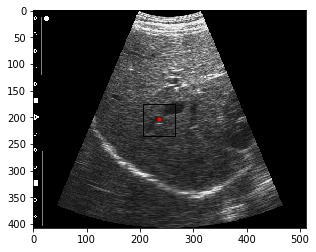

In [50]:
from matplotlib.patches import Rectangle
def plot_img_template(c1,c2,img, width=50, height=50):
    plt.clf()
    x = c1 - width/2
    y = c2 - height/2
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax.scatter(c1-1, c2-1, s=10, color='red')
    rect=Rectangle((x,y), width, height, fill=False)
    ax.add_patch(rect)
    plt.show()
i = 1
c1, c2 = pred_feat1.loc[pred_feat1['id']==i, ['c1', 'c2']].values[0]
try:
    img = np.asarray(Image.open(os.path.join(img_dir, '{:04d}.png'.format(int(i)))))
except FileNotFoundError:
    img = np.asarray(Image.open(os.path.join(img_dir, '{:05d}.png'.format(int(i)))))
plot_img_template(c1, c2, img, width=60, height=60)

### Visualize the temporal evolution of feature location

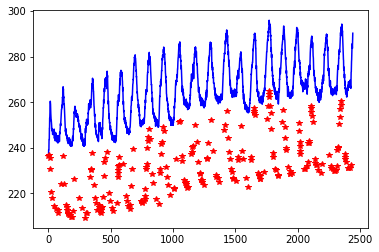

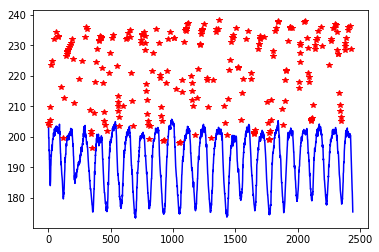

In [51]:
plt.plot(pred_feat1.id, pred_feat1.c1, 'b')
plt.plot(true_feat1.id, true_feat1.c1, 'r*')
plt.show()
plt.plot(pred_feat1.id, pred_feat1.c2, 'b')
plt.plot(true_feat1.id, true_feat1.c2, 'r*')
plt.show()

### Visualize the tracking as a video

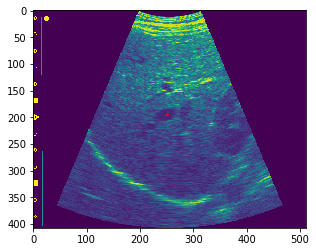

None

In [56]:
c1_list = pred_feat1.loc[:, 'c1'].values
c2_list = pred_feat1.loc[:,'c2'].values
for i in range(1,100,1):
    try:
        img = np.asarray(Image.open(os.path.join(img_dir, '{:05d}.png'.format(i))))
    except FileNotFoundError:
        img = np.asarray(Image.open(os.path.join(img_dir, '{:04d}.png'.format(i))))
    plt.clf()
    plt.imshow(img)
    plt.scatter(c1_list[i-1], c2_list[i-1], 3, 'r')
    display.clear_output(wait=True)
    display.display(plt.show())
    time.sleep(1)

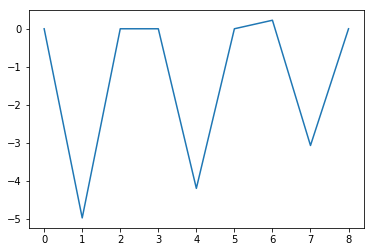

[ 0.         -4.98423624  0.          0.         -4.20547501  0.
  0.22468724 -3.07590017  0.        ]


In [53]:
plt.plot(c2_list[1:10]-c2_list[0:(10-1)])
plt.show()
print(c2_list[1:10]-c2_list[0:(10-1)])

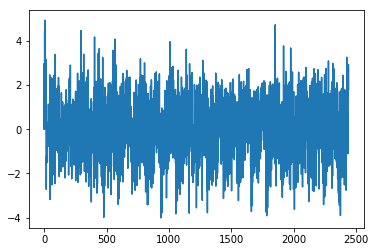

In [54]:
plt.plot(c1_list[1:len(c1_list)]-c1_list[0:len(c1_list)-1])
plt.show()

In [30]:
pred_feat1.head()

,id,c1,c2
0,1,236.230280,204.676970
1,2,236.230280,204.676970
2,3,242.670258,197.262604
3,4,249.922440,193.856567
4,5,256.235809,186.121628
